# 🎯 UTKFace Yaş-Cinsiyet Tahmini (CORAL Ordinal Regression + YOLO Filtreleme)

**CORAL (Consistent Rank Logits):** Yaşı sıralı (ordinal) sınıflandırma problemi olarak ele alır.

### 🔍 YOLO ile Veri Filtreleme (YENİ!)
Veri setinde hatalı etiketler olabilir. Bu yüzden her görüntüyü önce YOLO yüz tespit modelinden geçiriyoruz:
- ✅ **%100 Yüz Garantisi:** YOLO yüz tespit edemezse görüntü veri setine dahil edilmez
- ✅ **Temiz Crop:** YOLO'nun bulduğu yüz bölgesi crop'lanarak modele verilir
- ✅ **Gürültü Azaltma:** Yanlış etiketlenmiş/bozuk görüntüler otomatik elenir

### Neden CORAL?
- Yaş sıralamalı bir değişken (5 < 10 < 20 < 30...)
- Standart regression bu sıralamayı görmezden gelir
- CORAL, her yaş eşiği için "bu yaştan büyük mü?" sorusunu sorar

### Mimari:
- ✅ **YOLO Face Detection:** Veri filtreleme + yüz crop
- ✅ **Nested Multi-task:** Gender → Race → Age
- ✅ **CORAL Loss:** Ordinal regression
- ✅ **Inverse Frequency Weighting:** Dengeli öğrenme

## 1) Kurulum

In [1]:
import sys, subprocess

subprocess.check_call([
    sys.executable, '-m', 'pip', 'install', '-q',
    'pandas', 'numpy', 'matplotlib', 'scikit-learn', 'Pillow',
    'torch', 'torchvision', 'timm', 'tqdm', 'ultralytics'
])
print("✅ Kurulum tamamlandı (YOLO dahil)")

✅ Kurulum tamamlandı (YOLO dahil)


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import timm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from ultralytics import YOLO

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {DEVICE}")

/home/q/Desktop/youtube/sude/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🖥️ Device: cuda


## 2) Sabitler ve Veri Hazırlığı

In [3]:
# =====================================================
# 📌 SABİTLER
# =====================================================

IMAGE_DIR = 'data/utkface/UTKFace'  # Kendi yolunuzu yazın

AGE_MIN, AGE_MAX = 1, 90
NUM_GENDER = 2
NUM_RACE = 5

# CORAL için yaş sınırları (thresholds)
# Her threshold: "Yaş >= threshold mı?"
# 2'şerli artışlarla: 2, 4, 6, 8, ..., 88, 90
AGE_THRESHOLDS = list(range(2, 91, 2))  # [2, 4, 6, 8, ..., 88, 90] = 45 threshold
NUM_THRESHOLDS = len(AGE_THRESHOLDS)

# YOLO Face Detector için ayarlar
YOLO_MODEL_PATH = "face_yolo_best.pt"  # Eğitilmiş YOLO yüz modeli
YOLO_CONF_THRESHOLD = 0.4  # Güven eşiği

print(f"📊 CORAL Thresholds ({NUM_THRESHOLDS} adet):")
print(f"   {AGE_THRESHOLDS[:10]} ... {AGE_THRESHOLDS[-5:]}")
print(f"\n   Her örnek için {NUM_THRESHOLDS} binary karar:")
print(f"   'Yaş >= 2?', 'Yaş >= 4?', 'Yaş >= 6?', ..., 'Yaş >= 90?'")
print(f"\n🔍 YOLO Face Detection:")
print(f"   Model: {YOLO_MODEL_PATH}")
print(f"   Confidence Threshold: {YOLO_CONF_THRESHOLD}")

📊 CORAL Thresholds (45 adet):
   [2, 4, 6, 8, 10, 12, 14, 16, 18, 20] ... [82, 84, 86, 88, 90]

   Her örnek için 45 binary karar:
   'Yaş >= 2?', 'Yaş >= 4?', 'Yaş >= 6?', ..., 'Yaş >= 90?'

🔍 YOLO Face Detection:
   Model: face_yolo_best.pt
   Confidence Threshold: 0.4


In [4]:
# =====================================================
# 🔍 YOLO FACE DETECTOR YÜKLEME
# =====================================================

# YOLO modelini yükle
try:
    yolo_face_detector = YOLO(YOLO_MODEL_PATH)
    print(f"✅ YOLO Face Detector yüklendi: {YOLO_MODEL_PATH}")
except Exception as e:
    print(f"⚠️ Custom YOLO model bulunamadı ({e}), varsayılan yükleniyor...")
    yolo_face_detector = YOLO("yolov8n.pt")
    print("✅ Varsayılan YOLOv8n yüklendi")


def detect_face_yolo(image_path, detector, conf_threshold=0.4):
    """
    YOLO ile yüz tespiti yap ve en güvenilir yüz crop'ını döndür.
    
    Args:
        image_path: Görüntü dosya yolu
        detector: YOLO model instance
        conf_threshold: Minimum güven eşiği
    
    Returns:
        face_crop (PIL.Image) veya None (yüz bulunamadıysa)
        confidence (float) veya 0.0
    """
    try:
        # OpenCV ile oku (YOLO BGR bekler)
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            return None, 0.0
        
        # YOLO inference
        results = detector(img_bgr, conf=conf_threshold, verbose=False)[0]
        
        if results.boxes is None or len(results.boxes) == 0:
            return None, 0.0
        
        # En yüksek confidence'lı yüzü al
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        best_idx = confs.argmax()
        
        x1, y1, x2, y2 = map(int, boxes[best_idx])
        confidence = confs[best_idx]
        
        # Crop alanını kontrol et
        h, w = img_bgr.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        if x2 <= x1 or y2 <= y1:
            return None, 0.0
        
        # Crop ve RGB'ye çevir
        face_crop_bgr = img_bgr[y1:y2, x1:x2]
        face_crop_rgb = cv2.cvtColor(face_crop_bgr, cv2.COLOR_BGR2RGB)
        
        # PIL Image'a çevir
        face_pil = Image.fromarray(face_crop_rgb)
        
        return face_pil, float(confidence)
    
    except Exception as e:
        return None, 0.0


# Test: Bir örnek görüntüde YOLO çalıştır
test_images = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.jpg')][:3]
print(f"\n🧪 YOLO Test (ilk 3 görüntü):")
for fname in test_images:
    fpath = os.path.join(IMAGE_DIR, fname)
    face, conf = detect_face_yolo(fpath, yolo_face_detector, YOLO_CONF_THRESHOLD)
    status = f"✅ Yüz bulundu (conf={conf:.2f})" if face else "❌ Yüz bulunamadı"
    print(f"   {fname}: {status}")

✅ YOLO Face Detector yüklendi: face_yolo_best.pt

🧪 YOLO Test (ilk 3 görüntü):
   29_1_1_20170116001830007.jpg.chip.jpg: ✅ Yüz bulundu (conf=0.87)
   36_1_0_20170105164705002.jpg.chip.jpg: ✅ Yüz bulundu (conf=0.97)
   51_0_1_20170117173642448.jpg.chip.jpg: ✅ Yüz bulundu (conf=0.86)


In [5]:
# =====================================================
# 📊 VERİ HAZIRLAMA (YOLO FİLTRELİ)
# =====================================================

print("🔍 YOLO ile veri seti filtreleniyor...")
print("   Bu işlem biraz zaman alabilir...\n")

# Dosya isimlerinden metadata çıkar VE YOLO ile doğrula
records = []
skipped_no_face = 0
skipped_invalid = 0

all_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.jpg')]
total_files = len(all_files)

for i, fname in enumerate(tqdm(all_files, desc="YOLO Filtreleme")):
    # Dosya adından metadata çıkar
    parts = fname.split('_')
    try:
        age = int(parts[0])
        gender = int(parts[1])  # 0: Male, 1: Female
        race = int(parts[2])    # 0-4
    except:
        skipped_invalid += 1
        continue
    
    # Yaş aralığı kontrolü
    if not (AGE_MIN <= age <= AGE_MAX):
        skipped_invalid += 1
        continue
    
    # YOLO ile yüz kontrolü
    img_path = os.path.join(IMAGE_DIR, fname)
    face_crop, conf = detect_face_yolo(img_path, yolo_face_detector, YOLO_CONF_THRESHOLD)
    
    if face_crop is None:
        skipped_no_face += 1
        continue
    
    # Başarılı: YOLO yüz tespit etti
    records.append({
        'file': fname,
        'age': age,
        'gender': gender,
        'race': race,
        'yolo_conf': conf
    })

df = pd.DataFrame(records)

print(f"\n" + "=" * 70)
print(f"📊 YOLO FİLTRELEME SONUÇLARI")
print("=" * 70)
print(f"   Toplam dosya: {total_files}")
print(f"   ✅ YOLO ile doğrulanmış: {len(df)} ({100*len(df)/total_files:.1f}%)")
print(f"   ❌ Yüz bulunamadı: {skipped_no_face} ({100*skipped_no_face/total_files:.1f}%)")
print(f"   ⚠️ Geçersiz dosya adı: {skipped_invalid}")
print("=" * 70)

# YOLO güven dağılımı
print(f"\n🔍 YOLO Güven Dağılımı:")
print(f"   Min: {df['yolo_conf'].min():.3f}")
print(f"   Max: {df['yolo_conf'].max():.3f}")
print(f"   Ortalama: {df['yolo_conf'].mean():.3f}")

# Yaş bin'leri (ağırlık hesaplama için)
df['age_bin'] = pd.cut(
    df.age,
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 100],
    labels=False
)

# CORAL labels oluştur: Her threshold için binary label
def create_coral_labels(age, thresholds):
    """Yaş için CORAL binary labels oluştur.
    Örnek: age=25, thresholds=[5,10,15,20,25,30,...]
    Labels: [1, 1, 1, 1, 1, 0, 0, ...] (25 >= 5,10,15,20,25 ama < 30)
    """
    return [1 if age >= t else 0 for t in thresholds]

# Train/Val/Test split
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df[['age_bin', 'gender']]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[['age_bin', 'gender']]
)

print(f'\n📊 Veri Bölümü:')
print(f'   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')

🔍 YOLO ile veri seti filtreleniyor...
   Bu işlem biraz zaman alabilir...



YOLO Filtreleme: 100%|██████████████████████████████████████████████| 23708/23708 [02:05<00:00, 188.73it/s]



📊 YOLO FİLTRELEME SONUÇLARI
   Toplam dosya: 23708
   ✅ YOLO ile doğrulanmış: 23369 (98.6%)
   ❌ Yüz bulunamadı: 249 (1.1%)
   ⚠️ Geçersiz dosya adı: 90

🔍 YOLO Güven Dağılımı:
   Min: 0.400
   Max: 0.992
   Ortalama: 0.907

📊 Veri Bölümü:
   Train: 16358 | Val: 3505 | Test: 3506


## 3) Veri Analizi ve Ağırlık Hesaplama

In [6]:
print("=" * 70)
print("📊 VERİ DAĞILIMI ANALİZİ")
print("=" * 70)

# Yaş dağılımı
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
NUM_AGE_BINS = len(bin_labels)

print("\n📈 Yaş Bin Dağılımı:")
for b, label in enumerate(bin_labels):
    cnt = (train_df['age_bin'] == b).sum()
    pct = cnt / len(train_df) * 100
    print(f"   {label}: {cnt:5d} ({pct:5.1f}%)")

# Cinsiyet dağılımı
print("\n👫 Cinsiyet Dağılımı:")
for g, name in enumerate(['Erkek', 'Kadın']):
    cnt = (train_df['gender'] == g).sum()
    pct = cnt / len(train_df) * 100
    print(f"   {name}: {cnt:5d} ({pct:5.1f}%)")

📊 VERİ DAĞILIMI ANALİZİ

📈 Yaş Bin Dağılımı:
   0-10:  2244 ( 13.7%)
   10-20:  1156 (  7.1%)
   20-30:  5374 ( 32.9%)
   30-40:  3004 ( 18.4%)
   40-50:  1458 (  8.9%)
   50-60:  1532 (  9.4%)
   60-70:   807 (  4.9%)
   70+:   783 (  4.8%)

👫 Cinsiyet Dağılımı:
   Erkek:  8561 ( 52.3%)
   Kadın:  7797 ( 47.7%)


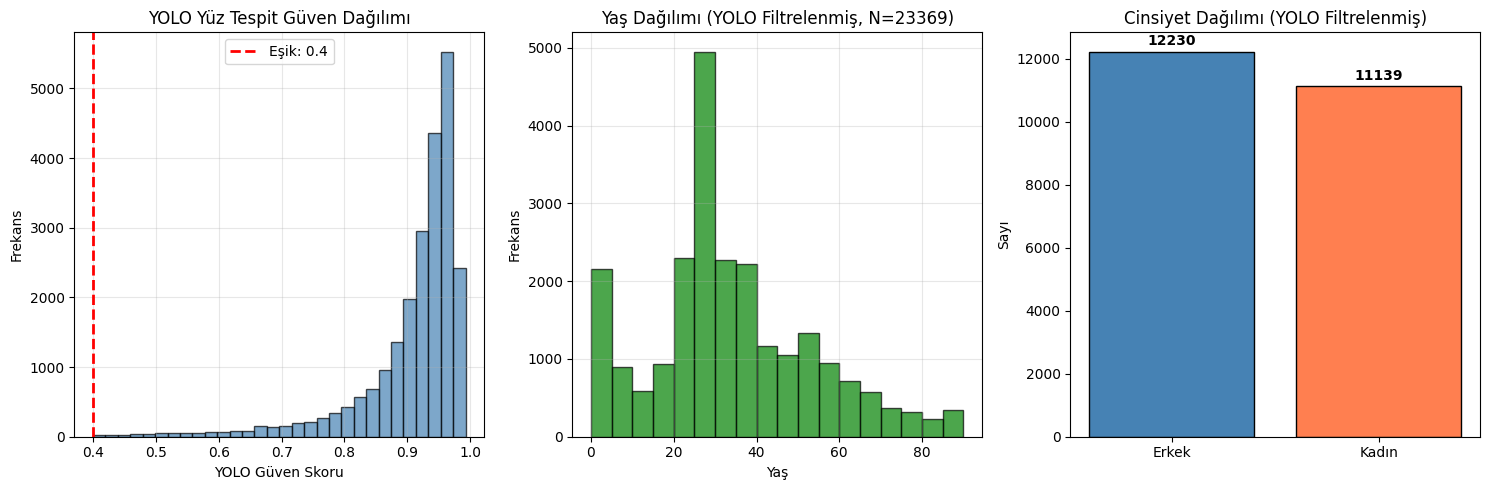

📊 Grafik kaydedildi: yolo_filtering_stats.png


In [7]:
# =====================================================
# 📊 YOLO FİLTRELEME GÖRSELLEŞTİRME
# =====================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. YOLO Güven Dağılımı
ax1 = axes[0]
ax1.hist(df['yolo_conf'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(YOLO_CONF_THRESHOLD, color='red', linestyle='--', linewidth=2, 
            label=f'Eşik: {YOLO_CONF_THRESHOLD}')
ax1.set_xlabel('YOLO Güven Skoru')
ax1.set_ylabel('Frekans')
ax1.set_title('YOLO Yüz Tespit Güven Dağılımı')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Yaş Dağılımı (YOLO filtrelenmiş)
ax2 = axes[1]
ax2.hist(df['age'], bins=range(0, 95, 5), edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('Yaş')
ax2.set_ylabel('Frekans')
ax2.set_title(f'Yaş Dağılımı (YOLO Filtrelenmiş, N={len(df)})')
ax2.grid(True, alpha=0.3)

# 3. Cinsiyet Dağılımı
ax3 = axes[2]
gender_counts = df['gender'].value_counts().sort_index()
bars = ax3.bar(['Erkek', 'Kadın'], gender_counts.values, 
               color=['steelblue', 'coral'], edgecolor='black')
ax3.set_ylabel('Sayı')
ax3.set_title('Cinsiyet Dağılımı (YOLO Filtrelenmiş)')
for bar, count in zip(bars, gender_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('yolo_filtering_stats.png', dpi=150)
plt.show()
print("📊 Grafik kaydedildi: yolo_filtering_stats.png")

In [8]:
# =====================================================
# ⚖️ CLASS WEIGHTS (Inverse Frequency - Clamped)
# =====================================================

print("=" * 70)
print("⚖️ CLASS WEIGHTS")
print("=" * 70)

# Cinsiyet ağırlıkları
gender_counts = train_df['gender'].value_counts().sort_index()
gender_weights = len(train_df) / (NUM_GENDER * gender_counts)
gender_weights = gender_weights.clip(0.8, 1.2)
gender_weights_tensor = torch.tensor(gender_weights.values, dtype=torch.float32).to(DEVICE)
print(f"\n👫 Cinsiyet: Erkek={gender_weights.iloc[0]:.3f}, Kadın={gender_weights.iloc[1]:.3f}")

# Irk ağırlıkları
race_counts = train_df['race'].value_counts().sort_index()
race_weights = len(train_df) / (NUM_RACE * race_counts)
race_weights = race_weights.clip(0.5, 2.0)
race_weights_tensor = torch.tensor(race_weights.values, dtype=torch.float32).to(DEVICE)
race_names = ['White', 'Black', 'Asian', 'Indian', 'Other']
print(f"\n🌍 Irk Ağırlıkları:")
for r, name in enumerate(race_names):
    print(f"   {name}: {race_weights.iloc[r]:.3f}")

# Yaş bin ağırlıkları (CORAL importance weighting için)
bin_counts = train_df['age_bin'].value_counts().sort_index()
age_bin_weights_raw = len(train_df) / (NUM_AGE_BINS * bin_counts)

AGE_BIN_WEIGHTS = {}
for b in range(NUM_AGE_BINS):
    raw_weight = age_bin_weights_raw.iloc[b] if b < len(age_bin_weights_raw) else 1.0
    clamped_weight = max(0.5, min(2.5, raw_weight))
    AGE_BIN_WEIGHTS[b] = clamped_weight

print(f"\n📊 Yaş Bin Ağırlıkları (CORAL için):")
for b, label in enumerate(bin_labels):
    print(f"   {label}: {AGE_BIN_WEIGHTS[b]:.3f}")

⚖️ CLASS WEIGHTS

👫 Cinsiyet: Erkek=0.955, Kadın=1.049

🌍 Irk Ağırlıkları:
   White: 0.500
   Black: 1.049
   Asian: 1.374
   Indian: 1.203
   Other: 2.000

📊 Yaş Bin Ağırlıkları (CORAL için):
   0-10: 0.911
   10-20: 1.769
   20-30: 0.500
   30-40: 0.681
   40-50: 1.402
   50-60: 1.335
   60-70: 2.500
   70+: 2.500


## 4) Dataset ve DataLoader

In [9]:
class UTKFaceDatasetCORAL(Dataset):
    """
    UTKFace Dataset with CORAL ordinal labels.
    YOLO ile yüz tespiti yapılarak sadece doğrulanmış yüzler kullanılır.
    """
    
    def __init__(self, df, image_dir, thresholds, transform=None, 
                 use_yolo_crop=True, yolo_detector=None, yolo_conf=0.4):
        """
        Args:
            df: Veri çerçevesi (YOLO ile önceden filtrelenmiş)
            image_dir: Görüntü dizini
            thresholds: CORAL yaş eşikleri
            transform: Görüntü dönüşümleri
            use_yolo_crop: True ise YOLO crop kullan, False ise orijinal görüntü
            yolo_detector: YOLO model instance
            yolo_conf: YOLO güven eşiği
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.thresholds = thresholds
        self.transform = transform
        self.use_yolo_crop = use_yolo_crop
        self.yolo_detector = yolo_detector
        self.yolo_conf = yolo_conf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file'])
        
        # YOLO crop veya orijinal görüntü
        if self.use_yolo_crop and self.yolo_detector is not None:
            face_crop, _ = detect_face_yolo(
                img_path, self.yolo_detector, self.yolo_conf
            )
            if face_crop is not None:
                image = face_crop
            else:
                # Fallback: orijinal görüntü
                image = Image.open(img_path).convert('RGB')
        else:
            image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        age = int(row['age'])
        age_bin = int(row['age_bin'])
        gender = int(row['gender'])
        race = int(row['race'])
        
        # CORAL labels: [1,1,1,1,0,0,0,...] şeklinde
        coral_labels = create_coral_labels(age, self.thresholds)

        return (
            image,
            torch.tensor(coral_labels, dtype=torch.float32),  # CORAL targets
            torch.tensor(age, dtype=torch.float32),           # Gerçek yaş (MAE için)
            torch.tensor(age_bin, dtype=torch.long),          # Bin (weighting için)
            torch.tensor(gender, dtype=torch.long),
            torch.tensor(race, dtype=torch.long),
        )

In [10]:
# Augmentation
train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# =====================================================
# 🎯 YOLO CROP SEÇENEĞİ
# =====================================================
# True: Her görüntüde YOLO çalıştırıp yüz crop'ı kullan (daha temiz veri)
# False: Orijinal görüntüleri kullan (daha hızlı, YOLO sadece filtreleme için)
USE_YOLO_CROP = True  # <-- Bunu değiştirerek deneyebilirsiniz

print(f"🎯 YOLO Crop Modu: {'AKTİF - Her görüntüde YOLO çalışacak' if USE_YOLO_CROP else 'KAPALI - Orijinal görüntüler kullanılacak'}")

# Datasets
train_dataset = UTKFaceDatasetCORAL(
    train_df, IMAGE_DIR, AGE_THRESHOLDS, 
    transform=train_tfms,
    use_yolo_crop=USE_YOLO_CROP,
    yolo_detector=yolo_face_detector,
    yolo_conf=YOLO_CONF_THRESHOLD
)

val_dataset = UTKFaceDatasetCORAL(
    val_df, IMAGE_DIR, AGE_THRESHOLDS, 
    transform=val_tfms,
    use_yolo_crop=USE_YOLO_CROP,
    yolo_detector=yolo_face_detector,
    yolo_conf=YOLO_CONF_THRESHOLD
)

test_dataset = UTKFaceDatasetCORAL(
    test_df, IMAGE_DIR, AGE_THRESHOLDS, 
    transform=val_tfms,
    use_yolo_crop=USE_YOLO_CROP,
    yolo_detector=yolo_face_detector,
    yolo_conf=YOLO_CONF_THRESHOLD
)

# DataLoaders
BATCH_SIZE = 64
# YOLO crop kullanılırken num_workers=0 önerilir (YOLO thread-safe değil)
NUM_WORKERS = 0 if USE_YOLO_CROP else 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoader hazır")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Num workers: {NUM_WORKERS}")
print(f"   YOLO ile doğrulanmış örnek sayısı: {len(df)}")

🎯 YOLO Crop Modu: AKTİF - Her görüntüde YOLO çalışacak
✅ DataLoader hazır
   Batch size: 64
   Num workers: 0
   YOLO ile doğrulanmış örnek sayısı: 23369


## 5) CORAL Model Tanımı

In [11]:
class NestedAgeModelCORAL(nn.Module):
    """
    Nested Multi-task Model with CORAL Ordinal Regression
    
    CORAL Mantığı:
    - K threshold için K binary classifier
    - Hepsi aynı feature'dan tek bir logit üretir
    - Her threshold için farklı bias: logit - bias_k
    - Consistent rank: P(age > t_k) > P(age > t_{k+1})
    
    Nested: Gender → Race → Age
    """
    
    def __init__(self, backbone='convnext_tiny', num_race=5, num_thresholds=17, pretrained=True):
        super().__init__()
        self.num_thresholds = num_thresholds
        
        # Backbone
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features
        
        # Gender Head
        self.gender_head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        
        # Race Head (gender conditioned)
        self.race_head = nn.Sequential(
            nn.Linear(feat_dim + 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_race)
        )
        
        # CORAL Age Head
        # Tek bir lineer katman (bias yok) → tüm thresholds için ortak logit
        self.coral_fc = nn.Linear(feat_dim + 2 + num_race, 1, bias=False)
        
        # Her threshold için ayrı bias (öğrenilebilir)
        # Sıralı olması için başlangıçta artan değerler
        initial_bias = torch.linspace(-3, 3, num_thresholds)
        self.coral_bias = nn.Parameter(initial_bias)
        
    def forward(self, x):
        # Backbone features
        feat = self.backbone(x)
        
        # Gender prediction
        gender_logits = self.gender_head(feat)
        gender_probs = torch.softmax(gender_logits, dim=1)
        
        # Race prediction (conditioned on gender)
        race_in = torch.cat([feat, gender_probs], dim=1)
        race_logits = self.race_head(race_in)
        race_probs = torch.softmax(race_logits, dim=1)
        
        # CORAL Age prediction
        age_in = torch.cat([feat, gender_probs, race_probs], dim=1)
        
        # Tek logit → tüm threshold'lar için
        base_logit = self.coral_fc(age_in)  # [B, 1]
        
        # Her threshold için: logit_k = base_logit - bias_k
        # coral_logits[k] = base_logit - bias[k]
        coral_logits = base_logit - self.coral_bias  # [B, num_thresholds]
        
        return gender_logits, race_logits, coral_logits
    
    def predict_age(self, coral_logits):
        """
        CORAL logits → Yaş tahmini
        
        Her threshold için P(age > t_k) = sigmoid(logit_k)
        Beklenen rank = sum(P(age > t_k))
        Yaş = interpolate(rank, thresholds)
        """
        probs = torch.sigmoid(coral_logits)  # [B, K]
        
        # Beklenen rank (kaç threshold geçildi)
        expected_rank = probs.sum(dim=1)  # [B]
        
        # Rank → Yaş dönüşümü (lineer interpolasyon)
        # rank=0 → AGE_MIN, rank=K → AGE_MAX
        age_pred = AGE_MIN + (expected_rank / self.num_thresholds) * (AGE_MAX - AGE_MIN)
        
        return age_pred


# Model oluştur
model = NestedAgeModelCORAL(
    backbone='convnext_tiny',
    num_race=NUM_RACE,
    num_thresholds=NUM_THRESHOLDS,
    pretrained=True
).to(DEVICE)

print(f"✅ CORAL Model oluşturuldu")
print(f"   Backbone: ConvNeXt-Tiny")
print(f"   Thresholds: {NUM_THRESHOLDS}")
print(f"   Toplam parametre: {sum(p.numel() for p in model.parameters()):,}")

✅ CORAL Model oluşturuldu
   Backbone: ConvNeXt-Tiny
   Thresholds: 45
   Toplam parametre: 28,216,987


## 6) CORAL Loss Fonksiyonu

In [12]:
def coral_loss(logits, labels, weights=None):
    """
    CORAL Loss: Binary cross-entropy for ordinal regression.
    
    Her threshold için ayrı BCE loss:
    L = -sum_k [ y_k * log(sigmoid(l_k)) + (1-y_k) * log(1-sigmoid(l_k)) ]
    
    Args:
        logits: [B, K] - her threshold için logit
        labels: [B, K] - binary labels (1 if age >= threshold)
        weights: [B] - örnek ağırlıkları (opsiyonel)
    
    Returns:
        Scalar loss
    """
    # Binary cross entropy (element-wise)
    bce = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')  # [B, K]
    
    # Threshold başına ortalama
    bce_per_sample = bce.mean(dim=1)  # [B]
    
    if weights is not None:
        # Ağırlıklı ortalama
        loss = (bce_per_sample * weights).sum() / weights.sum()
    else:
        loss = bce_per_sample.mean()
    
    return loss


def coral_loss_with_importance(logits, labels, age_bins):
    """
    CORAL Loss with importance weighting based on age bins.
    Az veri olan yaş gruplarına daha fazla ağırlık verir.
    """
    # Her örnek için bin bazlı ağırlık
    weights = torch.tensor(
        [AGE_BIN_WEIGHTS[int(b.item())] for b in age_bins],
        device=logits.device,
        dtype=torch.float32
    )
    
    return coral_loss(logits, labels, weights)


# Classification losses
criterion_gender = nn.CrossEntropyLoss(
    weight=gender_weights_tensor,
    label_smoothing=0.1
)

criterion_race = nn.CrossEntropyLoss(
    weight=race_weights_tensor,
    label_smoothing=0.1
)


# =====================================================
# ⚖️ LOSS AĞIRLIKLARI
# =====================================================
LOSS_WEIGHTS = {
    'gender': 0.3,
    'race': 0.2,
    'coral': 1.5,    # Ana görev (CORAL ordinal)
}

print("✅ CORAL Loss fonksiyonu tanımlandı")
print(f"\n📊 Loss Ağırlıkları:")
for k, v in LOSS_WEIGHTS.items():
    print(f"   {k}: {v}")

✅ CORAL Loss fonksiyonu tanımlandı

📊 Loss Ağırlıkları:
   gender: 0.3
   race: 0.2
   coral: 1.5


In [13]:
# Optimizer ve Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

print("✅ Optimizer: AdamW (lr=1e-4, weight_decay=1e-3)")
print("✅ Scheduler: CosineAnnealing (T_max=25)")

✅ Optimizer: AdamW (lr=1e-4, weight_decay=1e-3)
✅ Scheduler: CosineAnnealing (T_max=25)


## 7) Training ve Validation

In [14]:
def train_epoch(model, loader, optimizer, device):
    """Bir epoch eğitim (CORAL)"""
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    total_gender_acc = 0.0
    total_race_acc = 0.0
    n = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for images, coral_labels, age_raw, age_bin, gender, race in pbar:
        images = images.to(device)
        coral_labels = coral_labels.to(device)
        age_raw = age_raw.to(device)
        age_bin = age_bin.to(device)
        gender = gender.to(device)
        race = race.to(device)
        
        # Forward
        gender_logits, race_logits, coral_logits = model(images)
        
        # Losses
        loss_gender = criterion_gender(gender_logits, gender)
        loss_race = criterion_race(race_logits, race)
        loss_coral = coral_loss_with_importance(coral_logits, coral_labels, age_bin)
        
        # Total loss
        loss = (
            LOSS_WEIGHTS['gender'] * loss_gender +
            LOSS_WEIGHTS['race'] * loss_race +
            LOSS_WEIGHTS['coral'] * loss_coral
        )
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        # Metrics
        with torch.no_grad():
            age_pred = model.predict_age(coral_logits)
            mae = torch.mean(torch.abs(age_pred - age_raw)).item()
            gender_acc = (gender_logits.argmax(1) == gender).float().mean().item()
            race_acc = (race_logits.argmax(1) == race).float().mean().item()
        
        total_loss += loss.item()
        total_mae += mae
        total_gender_acc += gender_acc
        total_race_acc += race_acc
        n += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'mae': f'{mae:.2f}'})
    
    return total_loss/n, total_mae/n, total_gender_acc/n, total_race_acc/n


@torch.no_grad()
def validate_epoch(model, loader, device):
    """Validation (CORAL)"""
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    total_gender_acc = 0.0
    total_race_acc = 0.0
    n = 0
    
    for images, coral_labels, age_raw, age_bin, gender, race in loader:
        images = images.to(device)
        coral_labels = coral_labels.to(device)
        age_raw = age_raw.to(device)
        age_bin = age_bin.to(device)
        gender = gender.to(device)
        race = race.to(device)
        
        gender_logits, race_logits, coral_logits = model(images)
        
        loss_gender = criterion_gender(gender_logits, gender)
        loss_race = criterion_race(race_logits, race)
        loss_coral = coral_loss_with_importance(coral_logits, coral_labels, age_bin)
        
        loss = (
            LOSS_WEIGHTS['gender'] * loss_gender +
            LOSS_WEIGHTS['race'] * loss_race +
            LOSS_WEIGHTS['coral'] * loss_coral
        )
        
        age_pred = model.predict_age(coral_logits)
        mae = torch.mean(torch.abs(age_pred - age_raw)).item()
        gender_acc = (gender_logits.argmax(1) == gender).float().mean().item()
        race_acc = (race_logits.argmax(1) == race).float().mean().item()
        
        total_loss += loss.item()
        total_mae += mae
        total_gender_acc += gender_acc
        total_race_acc += race_acc
        n += 1
    
    return total_loss/n, total_mae/n, total_gender_acc/n, total_race_acc/n


print("✅ Training fonksiyonları hazır")

✅ Training fonksiyonları hazır


## 8) Eğitim

In [15]:
# Eğitim parametreleri
NUM_EPOCHS = 30
PATIENCE = 7
best_mae = float('inf')
no_improve = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'train_gender_acc': [], 'val_gender_acc': [],
    'train_race_acc': [], 'val_race_acc': []
}

print("🚀 CORAL EĞİTİM BAŞLIYOR")
print("=" * 70)
print(f"   Model: Nested + CORAL Ordinal Regression")
print(f"   Thresholds: {AGE_THRESHOLDS}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Patience: {PATIENCE}")
print("=" * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    # Train
    train_loss, train_mae, train_g_acc, train_r_acc = train_epoch(
        model, train_loader, optimizer, DEVICE
    )
    
    # Validate
    val_loss, val_mae, val_g_acc, val_r_acc = validate_epoch(
        model, val_loader, DEVICE
    )
    
    # Scheduler step
    scheduler.step()
    
    # History kaydet
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_gender_acc'].append(train_g_acc)
    history['val_gender_acc'].append(val_g_acc)
    history['train_race_acc'].append(train_r_acc)
    history['val_race_acc'].append(val_r_acc)
    
    # Log
    lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} | LR: {lr:.6f}")
    print(f"  Train - Loss: {train_loss:.4f} | MAE: {train_mae:.2f} | Gender: {train_g_acc:.1%} | Race: {train_r_acc:.1%}")
    print(f"  Val   - Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | Gender: {val_g_acc:.1%} | Race: {val_r_acc:.1%}")
    
    # CORAL bias değerlerini göster (sıralı olmalı)
    if epoch % 5 == 0:
        bias_vals = model.coral_bias.data.cpu().numpy()
        print(f"  CORAL Bias: [{bias_vals[0]:.2f}, ..., {bias_vals[-1]:.2f}] (monotonic: {all(bias_vals[i] <= bias_vals[i+1] for i in range(len(bias_vals)-1))})")
    
    # Early stopping
    if val_mae < best_mae:
        best_mae = val_mae
        no_improve = 0
        torch.save(model.state_dict(), 'best_age_model_coral.pth')
        print("  ✅ Best model saved!")
    else:
        no_improve += 1
        print(f"  ⚠️ No improvement ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print("\n🛑 Early stopping!")
            break

print("\n" + "=" * 70)
print("✅ CORAL EĞİTİM TAMAMLANDI")
print(f"   Best Validation MAE: {best_mae:.2f} yıl")
print("=" * 70)

🚀 CORAL EĞİTİM BAŞLIYOR
   Model: Nested + CORAL Ordinal Regression
   Thresholds: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90]
   Epochs: 30
   Patience: 7



Epoch 1/30 | LR: 0.000100
  Train - Loss: 0.9168 | MAE: 10.52 | Gender: 77.2% | Race: 48.6%
  Val   - Loss: 0.7229 | MAE: 6.66 | Gender: 87.6% | Race: 68.8%
  ✅ Best model saved!



Epoch 2/30 | LR: 0.000098
  Train - Loss: 0.6739 | MAE: 6.57 | Gender: 91.3% | Race: 74.9%
  Val   - Loss: 0.6555 | MAE: 5.76 | Gender: 91.1% | Race: 80.2%
  ✅ Best model saved!



Epoch 3/30 | LR: 0.000097
  Train - Loss: 0.6265 | MAE: 5.66 | Gender: 93.1% | Race: 80.7%
  Val   - Loss: 0.6418 | MAE: 6.10 | Gender: 92.3% | Race: 80.7%
  ⚠️ No improvement (1/7)



Epoch 4/30 | LR: 0.000094
  Train - Loss: 0.6003 | MAE: 5.14 | Gender: 93.9% | Race: 82.8%
  Val   - Loss: 0.6339 | MAE: 5.23 | Gender: 93.3% | Race: 80.8%
  ✅ Best model saved!



Epoch 5/30 | LR: 0.000091
  Train - Loss: 0.5808 | MAE: 4.80 | Gender: 95.1% | Race: 84.6%
  Val   - Loss: 0.6187 | MAE: 5.36 | Gender: 93.1% | Race: 81.3%
  CORAL Bias: [-3.14, ..., 3.13] (monotonic: True)
  ⚠️ No improvement (1/7)



Epoch 6/30 | LR: 0.000087
  Train - Loss: 0.5646 | MAE: 4.64 | Gender: 95.6% | Race: 86.4%
  Val   - Loss: 0.6210 | MAE: 5.15 | Gender: 93.1% | Race: 81.4%
  ✅ Best model saved!



Epoch 7/30 | LR: 0.000082
  Train - Loss: 0.5489 | MAE: 4.48 | Gender: 96.4% | Race: 88.1%
  Val   - Loss: 0.6118 | MAE: 4.99 | Gender: 92.4% | Race: 83.3%
  ✅ Best model saved!



Epoch 8/30 | LR: 0.000077
  Train - Loss: 0.5305 | MAE: 4.07 | Gender: 97.0% | Race: 90.2%
  Val   - Loss: 0.6063 | MAE: 5.00 | Gender: 93.6% | Race: 84.0%
  ⚠️ No improvement (1/7)


Training:  43%|███████████████                    | 110/256 [01:44<02:16,  1.07it/s, loss=0.4795, mae=3.63]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                           


Epoch 12/30 | LR: 0.000054
  Train - Loss: 0.4843 | MAE: 3.31 | Gender: 98.8% | Race: 95.8%
  Val   - Loss: 0.6227 | MAE: 5.00 | Gender: 92.7% | Race: 82.0%
  ⚠️ No improvement (5/7)



Epoch 13/30 | LR: 0.000047
  Train - Loss: 0.4786 | MAE: 3.19 | Gender: 98.9% | Race: 96.2%
  Val   - Loss: 0.6202 | MAE: 5.04 | Gender: 92.7% | Race: 82.6%
  ⚠️ No improvement (6/7)



Epoch 14/30 | LR: 0.000041
  Train - Loss: 0.4702 | MAE: 2.96 | Gender: 99.2% | Race: 97.6%
  Val   - Loss: 0.6249 | MAE: 4.89 | Gender: 91.5% | Race: 81.8%
  ✅ Best model saved!



Epoch 15/30 | LR: 0.000035
  Train - Loss: 0.4642 | MAE: 2.79 | Gender: 99.4% | Race: 98.2%
  Val   - Loss: 0.6133 | MAE: 4.87 | Gender: 93.4% | Race: 82.8%
  CORAL Bias: [-3.31, ..., 3.30] (monotonic: True)
  ✅ Best model saved!



Epoch 16/30 | LR: 0.000029
  Train - Loss: 0.4597 | MAE: 2.63 | Gender: 99.4% | Race: 98.6%
  Val   - Loss: 0.6146 | MAE: 4.92 | Gender: 93.1% | Race: 84.2%
  ⚠️ No improvement (1/7)



Epoch 17/30 | LR: 0.000024
  Train - Loss: 0.4558 | MAE: 2.49 | Gender: 99.6% | Race: 98.9%
  Val   - Loss: 0.6118 | MAE: 4.90 | Gender: 93.2% | Race: 84.0%
  ⚠️ No improvement (2/7)



Epoch 18/30 | LR: 0.000019
  Train - Loss: 0.4538 | MAE: 2.37 | Gender: 99.6% | Race: 99.0%
  Val   - Loss: 0.6106 | MAE: 4.91 | Gender: 93.0% | Race: 84.2%
  ⚠️ No improvement (3/7)



Epoch 19/30 | LR: 0.000014
  Train - Loss: 0.4513 | MAE: 2.23 | Gender: 99.7% | Race: 99.2%
  Val   - Loss: 0.6119 | MAE: 4.85 | Gender: 93.3% | Race: 84.8%
  ✅ Best model saved!



Epoch 20/30 | LR: 0.000010
  Train - Loss: 0.4496 | MAE: 2.14 | Gender: 99.7% | Race: 99.4%
  Val   - Loss: 0.6095 | MAE: 4.80 | Gender: 93.1% | Race: 84.9%
  CORAL Bias: [-3.34, ..., 3.33] (monotonic: True)
  ✅ Best model saved!



Epoch 21/30 | LR: 0.000007
  Train - Loss: 0.4489 | MAE: 2.08 | Gender: 99.7% | Race: 99.4%
  Val   - Loss: 0.6082 | MAE: 4.79 | Gender: 93.3% | Race: 84.3%
  ✅ Best model saved!



Epoch 22/30 | LR: 0.000004
  Train - Loss: 0.4476 | MAE: 2.00 | Gender: 99.8% | Race: 99.5%
  Val   - Loss: 0.6084 | MAE: 4.83 | Gender: 93.3% | Race: 84.7%
  ⚠️ No improvement (1/7)



Epoch 23/30 | LR: 0.000003
  Train - Loss: 0.4470 | MAE: 1.95 | Gender: 99.8% | Race: 99.5%
  Val   - Loss: 0.6096 | MAE: 4.83 | Gender: 93.3% | Race: 84.8%
  ⚠️ No improvement (2/7)



Epoch 24/30 | LR: 0.000001
  Train - Loss: 0.4464 | MAE: 1.91 | Gender: 99.8% | Race: 99.6%
  Val   - Loss: 0.6101 | MAE: 4.81 | Gender: 93.2% | Race: 84.8%
  ⚠️ No improvement (3/7)



Epoch 26/30 | LR: 0.000001
  Train - Loss: 0.4460 | MAE: 1.89 | Gender: 99.8% | Race: 99.6%
  Val   - Loss: 0.6093 | MAE: 4.83 | Gender: 93.1% | Race: 84.8%
  ⚠️ No improvement (5/7)



Epoch 27/30 | LR: 0.000003
  Train - Loss: 0.4459 | MAE: 1.88 | Gender: 99.8% | Race: 99.6%
  Val   - Loss: 0.6094 | MAE: 4.82 | Gender: 93.3% | Race: 84.8%
  ⚠️ No improvement (6/7)



Epoch 28/30 | LR: 0.000004
  Train - Loss: 0.4462 | MAE: 1.90 | Gender: 99.7% | Race: 99.6%
  Val   - Loss: 0.6094 | MAE: 4.80 | Gender: 93.1% | Race: 84.7%
  ⚠️ No improvement (7/7)

🛑 Early stopping!

✅ CORAL EĞİTİM TAMAMLANDI
   Best Validation MAE: 4.79 yıl


## 9) Eğitim Grafikleri

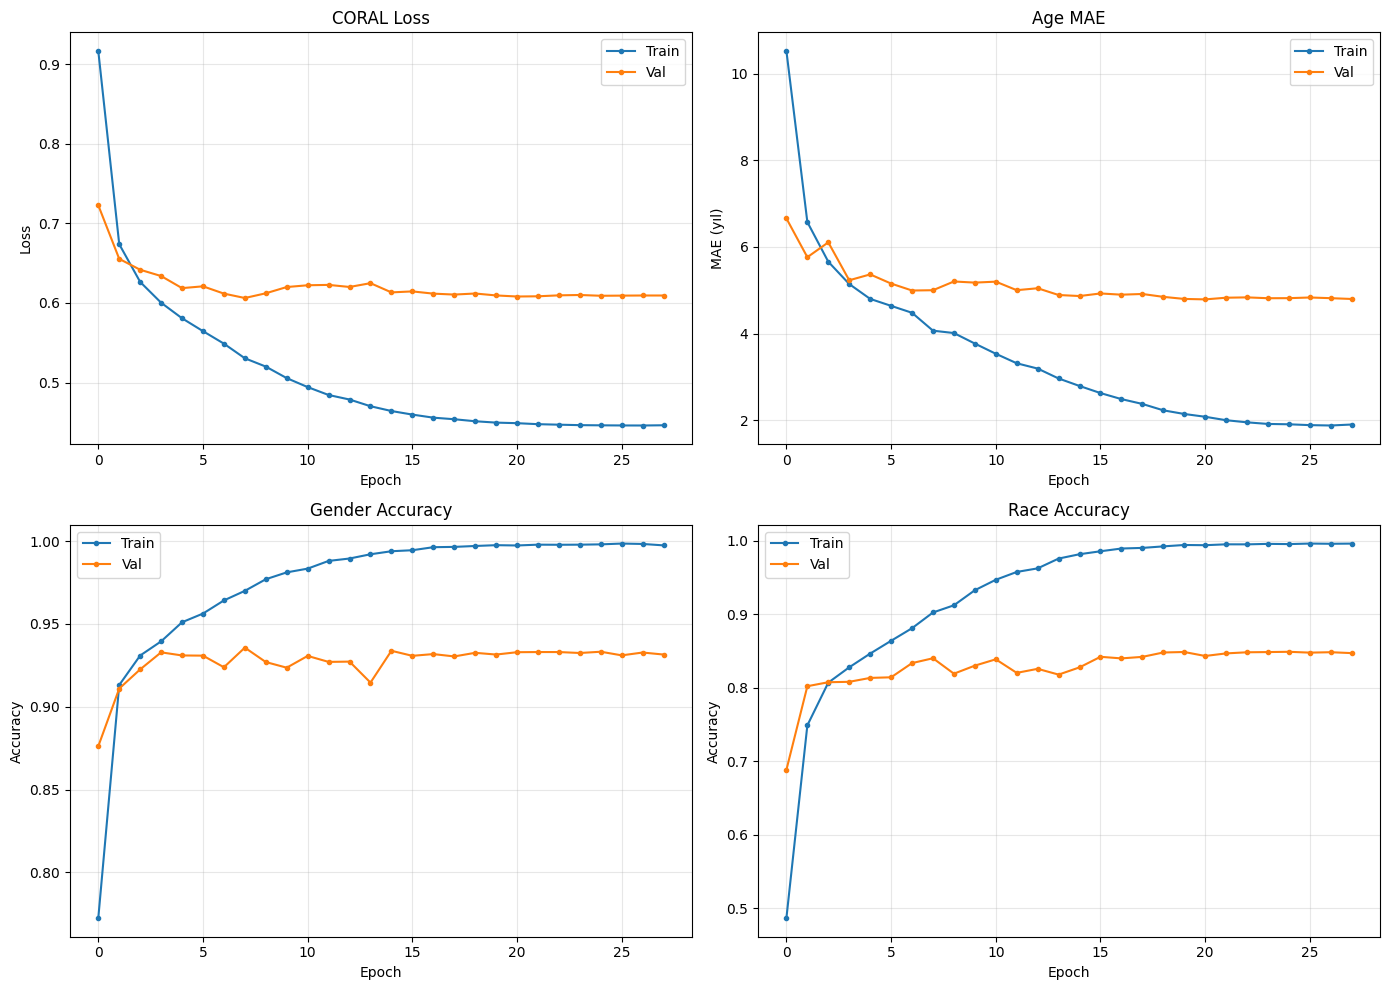

📊 Grafik kaydedildi: training_curves_coral.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train', marker='o', markersize=3)
ax1.plot(history['val_loss'], label='Val', marker='o', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('CORAL Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2 = axes[0, 1]
ax2.plot(history['train_mae'], label='Train', marker='o', markersize=3)
ax2.plot(history['val_mae'], label='Val', marker='o', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE (yıl)')
ax2.set_title('Age MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gender Accuracy
ax3 = axes[1, 0]
ax3.plot(history['train_gender_acc'], label='Train', marker='o', markersize=3)
ax3.plot(history['val_gender_acc'], label='Val', marker='o', markersize=3)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('Gender Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Race Accuracy
ax4 = axes[1, 1]
ax4.plot(history['train_race_acc'], label='Train', marker='o', markersize=3)
ax4.plot(history['val_race_acc'], label='Val', marker='o', markersize=3)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('Race Accuracy')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_coral.png', dpi=150)
plt.show()
print("📊 Grafik kaydedildi: training_curves_coral.png")

## 10) Test Değerlendirmesi

In [17]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_age_model_coral.pth', map_location=DEVICE))
model.eval()

# Test evaluation
test_loss, test_mae, test_g_acc, test_r_acc = validate_epoch(model, test_loader, DEVICE)

print("=" * 70)
print("📊 TEST SONUÇLARI (CORAL Model)")
print("=" * 70)
print(f"   Age MAE: {test_mae:.2f} yıl")
print(f"   Gender Accuracy: {test_g_acc:.1%}")
print(f"   Race Accuracy: {test_r_acc:.1%}")
print("=" * 70)

📊 TEST SONUÇLARI (CORAL Model)
   Age MAE: 4.89 yıl
   Gender Accuracy: 93.6%
   Race Accuracy: 86.0%


In [18]:
# CORAL Threshold Analysis
print("\n📊 CORAL THRESHOLD ANALİZİ")
print("=" * 70)

# Öğrenilen bias değerleri
bias_vals = model.coral_bias.data.cpu().numpy()
print(f"\n🎯 Öğrenilen Bias Değerleri:")
print(f"{'Threshold':<12} {'Bias':>10} {'Sigmoid(0-bias)':>18}")
print("-" * 45)
for t, b in zip(AGE_THRESHOLDS, bias_vals):
    prob = 1 / (1 + np.exp(b))  # sigmoid(-bias) = P(age > t | logit=0)
    print(f"   age >= {t:<4} {b:>10.3f} {prob:>18.1%}")

# Monotonicity check
is_monotonic = all(bias_vals[i] <= bias_vals[i+1] for i in range(len(bias_vals)-1))
print(f"\n✅ Monotonic (sıralı): {is_monotonic}")


📊 CORAL THRESHOLD ANALİZİ

🎯 Öğrenilen Bias Değerleri:
Threshold          Bias    Sigmoid(0-bias)
---------------------------------------------
   age >= 2        -3.340              96.6%
   age >= 4        -3.200              96.1%
   age >= 6        -3.061              95.5%
   age >= 8        -2.923              94.9%
   age >= 10       -2.784              94.2%
   age >= 12       -2.647              93.4%
   age >= 14       -2.508              92.5%
   age >= 16       -2.365              91.4%
   age >= 18       -2.221              90.2%
   age >= 20       -2.076              88.9%
   age >= 22       -1.928              87.3%
   age >= 24       -1.790              85.7%
   age >= 26       -1.635              83.7%
   age >= 28       -1.411              80.4%
   age >= 30       -1.225              77.3%
   age >= 32       -1.061              74.3%
   age >= 34       -0.908              71.3%
   age >= 36       -0.689              66.6%
   age >= 38       -0.540              63.2%


In [19]:
# Yaş grubu bazlı hata analizi
all_preds = []
all_targets = []
all_bins = []

model.eval()
with torch.no_grad():
    for images, coral_labels, age_raw, age_bin, gender, race in test_loader:
        images = images.to(DEVICE)
        gender_logits, race_logits, coral_logits = model(images)
        
        age_pred = model.predict_age(coral_logits)
        
        all_preds.extend(age_pred.cpu().numpy())
        all_targets.extend(age_raw.numpy())
        all_bins.extend(age_bin.numpy())

# DataFrame oluştur
error_df = pd.DataFrame({
    'true_age': all_targets,
    'pred_age': all_preds,
    'age_bin': all_bins
})
error_df['error'] = error_df['pred_age'] - error_df['true_age']
error_df['abs_error'] = error_df['error'].abs()

print("=" * 70)
print("📊 YAŞ GRUBU BAZLI MAE (CORAL)")
print("=" * 70)
print(f"{'Yaş Grubu':<12} {'MAE':>8} {'Std':>8} {'N':>8} {'Ağırlık':>10}")
print("-" * 50)

for b, label in enumerate(bin_labels):
    group = error_df[error_df['age_bin'] == b]
    if len(group) > 0:
        mae = group['abs_error'].mean()
        std = group['abs_error'].std()
        weight = AGE_BIN_WEIGHTS[b]
        print(f"{label:<12} {mae:>8.2f} {std:>8.2f} {len(group):>8} {weight:>10.3f}")

print("-" * 50)
print(f"{'TOPLAM':<12} {error_df['abs_error'].mean():>8.2f} {error_df['abs_error'].std():>8.2f} {len(error_df):>8}")

📊 YAŞ GRUBU BAZLI MAE (CORAL)
Yaş Grubu         MAE      Std        N    Ağırlık
--------------------------------------------------
0-10             1.82     3.04      482      0.911
10-20            4.30     3.47      247      1.769
20-30            4.07     3.94     1152      0.500
30-40            5.40     4.34      644      0.681
40-50            6.32     4.72      313      1.402
50-60            7.36     6.09      328      1.335
60-70            7.36     5.72      173      2.500
70+              8.05     7.77      167      2.500
--------------------------------------------------
TOPLAM           4.88     4.87     3506


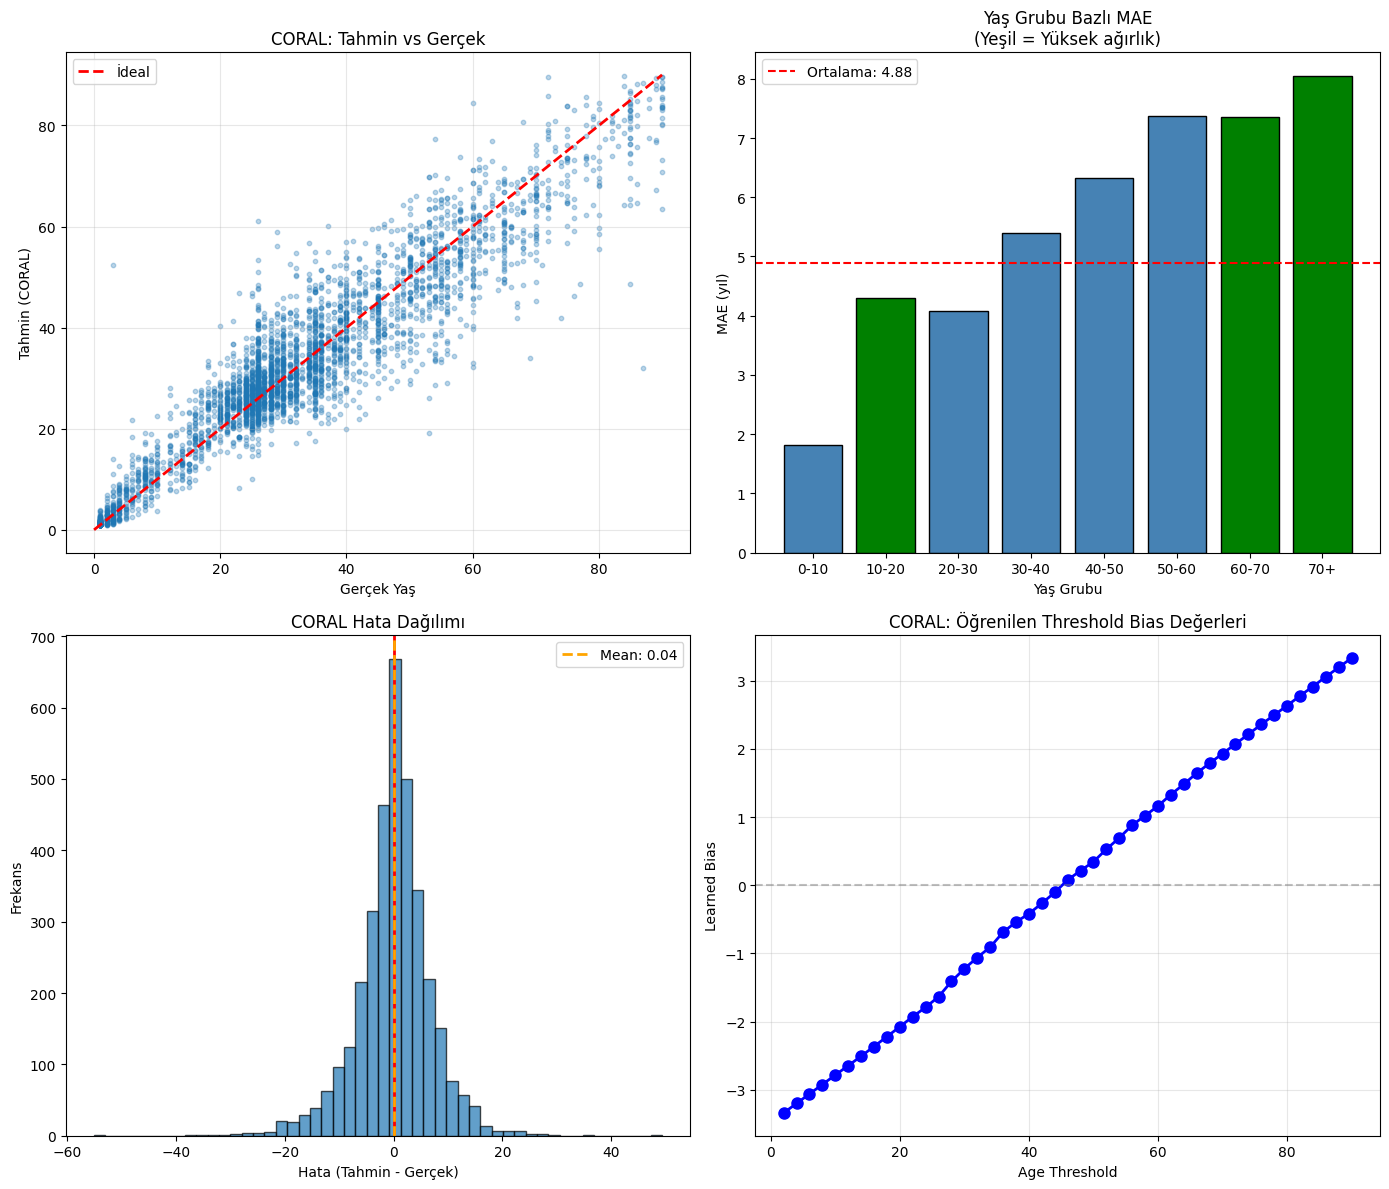

📊 Analiz kaydedildi: test_analysis_coral.png


In [20]:
# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Tahmin vs Gerçek
ax1 = axes[0, 0]
ax1.scatter(error_df['true_age'], error_df['pred_age'], alpha=0.3, s=10)
ax1.plot([0, 90], [0, 90], 'r--', linewidth=2, label='İdeal')
ax1.set_xlabel('Gerçek Yaş')
ax1.set_ylabel('Tahmin (CORAL)')
ax1.set_title('CORAL: Tahmin vs Gerçek')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Yaş grubu MAE
ax2 = axes[0, 1]
group_mae = error_df.groupby('age_bin')['abs_error'].mean()
colors = ['green' if AGE_BIN_WEIGHTS[i] > 1.5 else 'steelblue' for i in range(len(bin_labels))]
ax2.bar(bin_labels, group_mae.values, color=colors, edgecolor='black')
ax2.axhline(error_df['abs_error'].mean(), color='red', linestyle='--', label=f"Ortalama: {error_df['abs_error'].mean():.2f}")
ax2.set_xlabel('Yaş Grubu')
ax2.set_ylabel('MAE (yıl)')
ax2.set_title('Yaş Grubu Bazlı MAE\n(Yeşil = Yüksek ağırlık)')
ax2.legend()

# 3. Hata dağılımı
ax3 = axes[1, 0]
ax3.hist(error_df['error'], bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(0, color='red', linestyle='-', linewidth=2)
ax3.axvline(error_df['error'].mean(), color='orange', linestyle='--', linewidth=2, label=f"Mean: {error_df['error'].mean():.2f}")
ax3.set_xlabel('Hata (Tahmin - Gerçek)')
ax3.set_ylabel('Frekans')
ax3.set_title('CORAL Hata Dağılımı')
ax3.legend()

# 4. CORAL Bias visualization
ax4 = axes[1, 1]
ax4.plot(AGE_THRESHOLDS, bias_vals, 'bo-', markersize=8, linewidth=2)
ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Age Threshold')
ax4.set_ylabel('Learned Bias')
ax4.set_title('CORAL: Öğrenilen Threshold Bias Değerleri')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_analysis_coral.png', dpi=150)
plt.show()
print("📊 Analiz kaydedildi: test_analysis_coral.png")

## 11) CORAL vs Simple Regression Karşılaştırması

In [21]:
print("=" * 70)
print("📊 CORAL vs SIMPLE REGRESSION KARŞILAŞTIRMASI")
print("=" * 70)
print("""
┌─────────────────────────────────────────────────────────────────────┐
│                        CORAL AVANTAJLARI                            │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ✅ Ordinal Yapı: Yaşın sıralamalı doğasını korur                  │
│     5 < 10 < 20 ilişkisi explicit olarak modellenir                │
│                                                                     │
│  ✅ Consistent Predictions: P(age>30) >= P(age>40) garantili        │
│     Simple regression bunu garanti edemez                          │
│                                                                     │
│  ✅ Uncertainty: Her threshold için olasılık                        │
│     "Bu kişi 40'ın üzerinde olabilir: %70"                         │
│                                                                     │
│  ✅ Robust: Aşırı değerlere (outliers) daha dayanıklı              │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                        CORAL DEZAVANTAJLARI                         │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ⚠️ Discrete: Sadece threshold noktalarında hassas                 │
│     25 ile 29 arasını ayırt etmek zor                              │
│                                                                     │
│  ⚠️ Threshold seçimi kritik: Yanlış aralıklar performansı düşürür │
│                                                                     │
│  ⚠️ Daha karmaşık: Eğitim ve inference biraz daha yavaş           │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print(f"\n🎯 Bu modelin sonuçları:")
print(f"   Test MAE: {test_mae:.2f} yıl")
print(f"   Gender Accuracy: {test_g_acc:.1%}")
print(f"   Race Accuracy: {test_r_acc:.1%}")

📊 CORAL vs SIMPLE REGRESSION KARŞILAŞTIRMASI

┌─────────────────────────────────────────────────────────────────────┐
│                        CORAL AVANTAJLARI                            │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ✅ Ordinal Yapı: Yaşın sıralamalı doğasını korur                  │
│     5 < 10 < 20 ilişkisi explicit olarak modellenir                │
│                                                                     │
│  ✅ Consistent Predictions: P(age>30) >= P(age>40) garantili        │
│     Simple regression bunu garanti edemez                          │
│                                                                     │
│  ✅ Uncertainty: Her threshold için olasılık                        │
│     "Bu kişi 40'ın üzerinde olabilir: %70"                         │
│                                                                     │
│  ✅ Robust: Aşırı değerl

---
## 📌 Özet

### CORAL Ordinal Regression:

**Mantık:**
```
Yaş = 35 için CORAL labels:
Threshold:  5   10   15   20   25   30   35   40   45   ...
Label:      1    1    1    1    1    1    1    0    0   ...
            ↑ 35 >= 5   ↑ 35 >= 30   ↑ 35 < 40
```

**Model:**
```
logit_k = W·features - bias_k
P(age >= threshold_k) = sigmoid(logit_k)
Predicted Age = sum(P) * (max_age / num_thresholds)
```

**Avantaj:** Yaşın sıralamalı doğasını korur, tutarlı tahminler üretir.